In [17]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt
import time
from DeepQuantile import DQR
import numpy.random as rgt
from scipy.stats import norm, t
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from WAQR import WAQR, FullyConnectedNN
from joint import QuantES
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# 1.Parametric Model

This is an example of ES regression with $\tau=0.1$, following DGP1 of Chetverikov, Liu and Tsyvinski (2022)
where $Y=\varepsilon+X'\bar{\beta}$ with $\varepsilon\sim N(0,1)$. Will use half to train the quantile model, and feed half to train the second step.

In [18]:
B = 10
l2_err = np.zeros((B,3))
out_l2_err = np.zeros((B,3))
runtime = np.zeros((B,3))
n = 3000 # number of training samples
m = 5000 # number of test samples
p = 5
tau = 0.1

betabar = np.array([0.3,0.5,0,0,0])
betabar1=np.array([0.5,0.3,0.5,0,0,0])
itc=0.5

In [19]:
VaR = norm.ppf(tau)
SQ = norm.ppf(1-tau)
def tail_function(x) :
    return (x if x < VaR else 0)

def right_tail_function(x):
    return (x if x >SQ else 0)

CVaR = norm.expect(tail_function)/tau
CSQ = norm.expect(right_tail_function)/tau

In [64]:
for b in range(B):
    X = np.random.standard_normal(size=(n, p))
    Xbar= np.hstack((np.ones((n, 1)), X))
    # Add a column of ones as the first column of the matrix
    #X = np.hstack((np.ones((n, 1)), X))
    err = rgt.normal(0,1,n)
    Y = err +X.dot(betabar)+itc
    X_test = np.random.standard_normal(size=(m, p))
    # Add a column of ones as the first column of the matrix
    X_test_bar = np.hstack((np.ones((m, 1)), X_test))
    true_test_ES=X_test.dot(betabar) + CVaR +itc
    true_test_SQ=X_test.dot(betabar) + CSQ +itc
    
    waqr1 = WAQR(Xbar,Y,options={'depth' : 3})
    modells1 = waqr1.fit_ls(tau1=tau,intercept=False)
    betahat=modells1.coef_
    l2_err[b,0] = (np.mean((true_test_ES - modells1.predict(X_test_bar))**2))**0.5
    
    waqr2 = WAQR(Xbar,Y,options={'depth' : 3})
    modelnl1, trainloss = waqr2.fit_nl(tau1=tau,hidden_sizes=[48],dropout_rate=0,lr=0.1, batch_size=32, use_lr_decay=True)
    l2_err[b,1] = (np.mean((true_test_ES - modelnl1.predict(X_test_bar))**2))**0.5
    
    init = QuantES(X, Y)
    ## two-step least squares
    m1 = init.twostep_fit(tau=tau, loss='L2',standardize=True)
    l2_err[b,2] = (np.mean((true_test_ES - X_test_bar.dot(m1['coef_e']))**2))**0.5
    
    #m2 = init.joint_fit(tau=tau)
    #l2_err[b,2] = (np.mean((true_test_ES - X_test_bar.dot(m2['coef_e']))**2))**0.5
    

In [65]:
np.mean(l2_err, axis = 0)

array([0.10552338, 0.17907196, 0.07916918])

<ipython-input-66-476971ec3072>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.plot(np.array(trainloss), label='Training loss')
<ipython-input-66-476971ec3072>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(trainloss), label='Training loss')


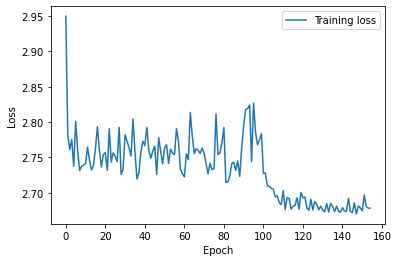

In [66]:
plt.plot(np.array(trainloss), label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
np.array(trainloss)

<ipython-input-67-80fce45b4a8f>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(trainloss)
<ipython-input-67-80fce45b4a8f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(trainloss)


array([tensor([2.9499]), tensor([2.7821]), tensor([2.7612]),
       tensor([2.7757]), tensor([2.7375]), tensor([2.8011]),
       tensor([2.7598]), tensor([2.7316]), tensor([2.7378]),
       tensor([2.7388]), tensor([2.7415]), tensor([2.7648]),
       tensor([2.7457]), tensor([2.7324]), tensor([2.7389]),
       tensor([2.7629]), tensor([2.7934]), tensor([2.7610]),
       tensor([2.7365]), tensor([2.7539]), tensor([2.7567]),
       tensor([2.7316]), tensor([2.7906]), tensor([2.7435]),
       tensor([2.7566]), tensor([2.7514]), tensor([2.7440]),
       tensor([2.7925]), tensor([2.7259]), tensor([2.7337]),
       tensor([2.7822]), tensor([2.7728]), tensor([2.7639]),
       tensor([2.7520]), tensor([2.8043]), tensor([2.7583]),
       tensor([2.7194]), tensor([2.7286]), tensor([2.7579]),
       tensor([2.7729]), tensor([2.7667]), tensor([2.7927]),
       tensor([2.7599]), tensor([2.7490]), tensor([2.7590]),
       tensor([2.7658]), tensor([2.7260]), tensor([2.7782]),
       tensor([2.7589]),

In [56]:
len(trainloss)

200

# 2. Nonparametric Model

In [68]:
B = 10
l2_err_np = np.zeros((B,3))

runtime = np.zeros((B,3))
n = 3000 # number of training samples
m = 5000 # number of test samples
p = 3
tau = 0.1



### (1)
$$ y = \sin(2\pi x_1^2) \sin(4\pi x_2) + 2x_3^2 + \epsilon$$

In [69]:
nonpar_function = lambda x : np.sin(2*np.pi*(x[:,0]))*np.sin(4*np.pi*x[:,1]) + 2*np.cos(x[:,2])

In [70]:
VaR = norm.ppf(tau)
SQ = norm.ppf(1-tau)
def tail_function(x) :
    return (x if x < VaR else 0)

def right_tail_function(x):
    return (x if x >SQ else 0)

CVaR = norm.expect(tail_function)/tau
CSQ = norm.expect(right_tail_function)/tau

In [82]:
for b in range(B):
    X = np.random.standard_normal(size=(n, p))
    err = rgt.normal(0,1,n)
    Y = err +nonpar_function(X)
    X_test = np.random.standard_normal(size=(m, p))
    X_test_bar = np.hstack((np.ones((m, 1)), X_test))
    # Add a column of ones as the first column of the matrix
    
    true_test_ES=nonpar_function(X_test) + CVaR 
    true_test_SQ=nonpar_function(X_test) + CSQ 
    
    waqr1 = WAQR(X,Y,options={'depth' : 3})
    modells1 = waqr1.fit_ls(tau1=tau,intercept=True)
    l2_err_np[b,0] = (np.mean((true_test_ES - modells1.predict(X_test))**2))**0.5
    
    modelnl1,train_losses = waqr1.fit_nl(tau1=tau,hidden_sizes=[128,128,128,128],dropout_rate=0.1,use_lr_decay=True,lr=0.05,batch_size=128)
    l2_err_np[b,1] = (np.mean((true_test_ES - modelnl1.predict(X_test))**2))**0.5
    
    init = QuantES(X, Y)
    ## two-step least squares
    m1 = init.twostep_fit(tau=tau, loss='L2',standardize=True)
    l2_err_np[b,2] = (np.mean((true_test_ES - X_test_bar.dot(m1['coef_e']))**2))**0.5
    
    #m2 = init.joint_fit(tau=tau)
    #l2_err[b,2] = (np.mean((true_test_ES - X_test_bar.dot(m2['coef_e']))**2))**0.5
    

In [83]:
np.mean(l2_err_np, axis = 0)

array([1.04416941, 0.6730943 , 1.39636885])

<ipython-input-84-bff1a3905ff6>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.plot(np.array(train_losses), label='Training loss')
<ipython-input-84-bff1a3905ff6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(train_losses), label='Training loss')


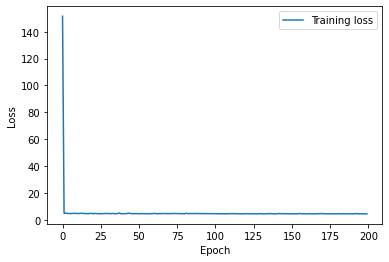

In [84]:
plt.plot(np.array(train_losses), label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
train_losses

[tensor([151.5643]),
 tensor([4.8083]),
 tensor([4.8852]),
 tensor([4.7214]),
 tensor([4.6324]),
 tensor([4.5800]),
 tensor([4.6665]),
 tensor([4.7468]),
 tensor([4.7661]),
 tensor([4.6846]),
 tensor([4.6880]),
 tensor([4.6111]),
 tensor([4.8226]),
 tensor([4.7098]),
 tensor([4.6239]),
 tensor([4.6149]),
 tensor([4.5184]),
 tensor([4.5432]),
 tensor([4.6723]),
 tensor([4.7433]),
 tensor([4.5126]),
 tensor([4.6487]),
 tensor([4.6400]),
 tensor([4.4871]),
 tensor([4.4784]),
 tensor([4.5060]),
 tensor([4.4980]),
 tensor([4.5921]),
 tensor([4.6277]),
 tensor([4.6609]),
 tensor([4.5938]),
 tensor([4.5184]),
 tensor([4.5168]),
 tensor([4.6900]),
 tensor([4.4996]),
 tensor([4.4247]),
 tensor([4.6443]),
 tensor([5.0252]),
 tensor([4.5362]),
 tensor([4.4620]),
 tensor([4.5289]),
 tensor([4.4316]),
 tensor([4.6017]),
 tensor([4.8557]),
 tensor([4.7838]),
 tensor([4.4841]),
 tensor([4.4890]),
 tensor([4.4928]),
 tensor([4.6169]),
 tensor([4.4921]),
 tensor([4.4479]),
 tensor([4.4708]),
 tensor([4